In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
all_cleaned = pd.read_csv('../data/all_cleaned.csv')

### Cosine 

<Axes: xlabel='mod_book_title'>

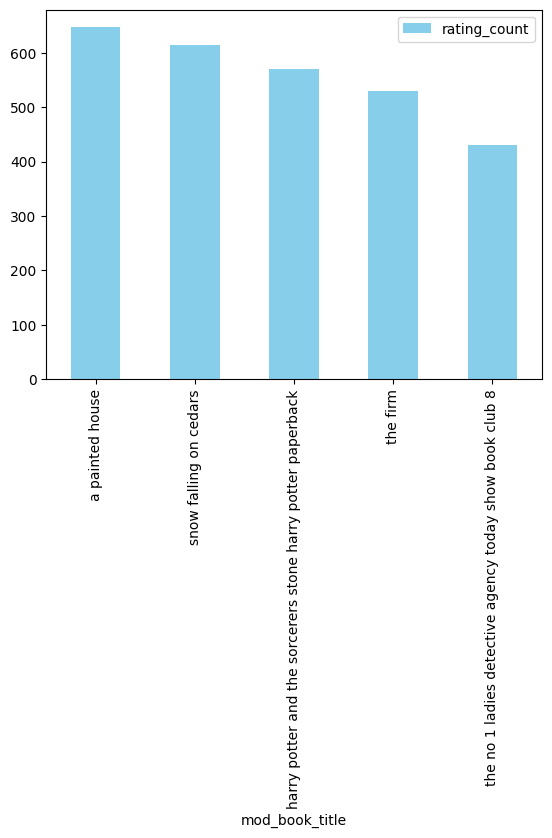

In [3]:
# Group by 'isbn' and count the number of ratings for each ISBN
isbn_rating_counts = all_cleaned.groupby(['mod_book_title', 'mod_book_author', 'isbn']).size().reset_index(name='rating_count')

# Display the DataFrame to verify the result
isbn_rating_counts.sort_values('rating_count', ascending=False).head().plot(kind='bar', x='mod_book_title', y='rating_count', color='skyblue')

In [4]:
# including the average rating for each book
# Calculate the average rating for each book

to_be_rated = all_cleaned[['isbn', 'book_rating']]
averageRating = to_be_rated.groupby('isbn')['book_rating'].mean().round(1).reset_index()
averageRating.rename(columns={'book_rating': 'average_rating'}, inplace=True)
average_rating = averageRating[['isbn','average_rating']]

# Merge the average ratings back with the original dataset
averageRatingdf = pd.merge(isbn_rating_counts, average_rating, on='isbn', how='left')

# Remove duplicate entries
#averageRatingdf = averageRatingdf[['isbn', 'average_rating']].drop_duplicates(subset=['isbn'])

averageRatingdf.head() 

,mod_book_title,mod_book_author,isbn,rating_count,average_rating
0,0815 heute,kirst,3442013453,1,7.0
1,1 2 3,tana hoban,068802579X,3,5.3
2,10 000 dreams interpreted,gustavus hindman miller,1862044082,1,0.0
3,100 chocolate,katherine khodorowsky,1577173074,1,0.0
4,1000 years 1000 people ranking the men and wom...,agnes hooper gottlieb,1568362536,4,6.8


In [5]:
# Reducing shape of dataframe

ratings = averageRatingdf[averageRatingdf['rating_count'] >= 15]    #filtering out books with less than 15 ratings
ratings.shape

(1488, 5)

In [6]:
# turning titles into TD-IDF matrix => Term Frequency-Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer takes a list of strings as input and turns it into a fd-idf matrix
vectorizer = TfidfVectorizer()

In [7]:
tdidf = vectorizer.fit_transform(ratings['mod_book_title'])

In [8]:
#to do comparison between books, we need to calculate the cosine similarity between the books

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re


# query function:

def search(query, vectorizer):
# setting up a search query

    #query = 'The Hobbit'
# preparing the string in the same way as the mod titles above
    processed = re.sub('[^a-zA-Z0-9]', ' ', query.lower())

# we need to turn the query into a vector using the vectorizer

    query_vector = vectorizer.transform([processed])

# to find the similarities we calculate the cosine similarity between the query vector and the tdidf matrix
    similarity = cosine_similarity(query_vector, tdidf).flatten() # flatten is used to turn the matrix into a 1D array

# to find the indices of the 10 largest similarities

    indices = np.argpartition(similarity, -10)[-10:]

# use indices to index the titles

    results = ratings.iloc[indices]   

# as there are many books with the title "The Hobbit", we only want those with the highest number of ratings

    results = results.sort_values(by='rating_count', ascending=False)

    return results.head(10)


In [9]:
search('wild animus', vectorizer)    

,mod_book_title,mod_book_author,isbn,rating_count,average_rating
6512,call of the wild,jack london,1559029838,180,2.4
45041,succulent wild woman,sark,068483376X,60,4.2
19142,free,paul vincent,1844262553,54,8.0
19251,friedhof der kuscheltiere roman,stephen king,3453007867,34,4.3
19016,fox river,emilie richards,1551668068,33,2.2
59934,zwlf,nick mcdonell,3462032283,27,2.9
58605,wild magic immortals paperback,tamora pierce,067988288X,26,3.8
43666,so wild a heart,candace camp,1551668777,20,3.3
19076,frankenstein doesnt plant petunias adventures ...,debbie dadey,059047071X,15,0.9
19204,french for cats all the french your cat will e...,henri de la barbe,067940676X,15,4.7


### Authors flagging

In [10]:
all_cleaned.head()

,isbn,book_title,book_author,year_of_publication,publisher,genre,user_id,book_rating,location,age,age_numeric,age_bins,mod_book_author,mod_book_title,mod_publisher,country,name_surname,surname
0,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,16634.0,0.0,"little rock, arkansas, usa",42.0,42.0,Adult,kitty kelley,the royals,bausch lombard,usa,kitty kelley,kelley
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,87141.0,0.0,"huntington beach, california, usa",unknown,NaN,unknown,kitty kelley,the royals,bausch lombard,usa,kitty kelley,kelley
2,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,169736.0,7.0,"minneapolis, minnesota, usa",34.0,34.0,Adult,kitty kelley,the royals,bausch lombard,usa,kitty kelley,kelley
3,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,208406.0,0.0,"kansas city, missouri, usa",30.0,30.0,Adult,kitty kelley,the royals,bausch lombard,usa,kitty kelley,kelley
4,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,unknown,230496.0,0.0,"simi valley, california, usa",34.0,34.0,Adult,kitty kelley,the royals,bausch lombard,usa,kitty kelley,kelley


In [11]:
all_cleaned['mod_book_author'].nunique()

33200

In [12]:
all_cleaned['mod_book_author'].unique()

array(['kitty kelley', 'edgar allan poe', 'dan brown', ..., 'j warner',
       'rachel abramowitz', 'ted schredd'], dtype=object)

In [13]:
# Filter rows where the continent is 'North America'
north_america_authors = all_cleaned[all_cleaned['continent'] == 'North America']['mod_book_author'].unique()

# Print the unique authors from North America
for author in north_america_authors:
    print(author)

KeyError: 'continent'

In [61]:
# Step 1: Filter the dataset to include only rows where the continent is 'North America'
north_america_data = all_cleaned[all_cleaned['continent'] == 'North America']

# Step 2: Group by 'mod_book_author' and count the number of times each author has been read
author_read_counts = north_america_data.groupby('mod_book_author').size().reset_index(name='read_count')

# Step 3: Sort by 'read_count' in descending order to get the most read authors
top_30_authors_na = author_read_counts.sort_values(by='read_count', ascending=False).head(30)

# Step 4: Display the top 20 most read authors in North America
print(top_30_authors_na)

                 mod_book_author  read_count
71043               stephen king        8565
57282               nora roberts        7763
37835               john grisham        7629
32802            james patterson        5287
14860             danielle steel        4590
51665         mary higgins clark        4303
16732              dean r koontz        3986
53404           michael crichton        3748
75081                 tom clancy        3581
3889                   anne rice        3346
71919                sue grafton        3317
33681            janet evanovich        2974
68145               sandra brown        2603
76215                 vc andrews        2557
31240                j k rowling        2356
56808            nicholas sparks        2308
61845                  r l stine        2280
58568  patricia daniels cornwell        2216
3182                anita shreve        2154
39216         jonathan kellerman        2123
48615               maeve binchy        2105
10524     

/var/folders/pp/kcbw8ksn7g9_pjm4p84cj6ym0000gn/T/ipykernel_42559/2002480603.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='read_count', y='mod_book_author', data=top_30_authors_na, palette='Blues_r')


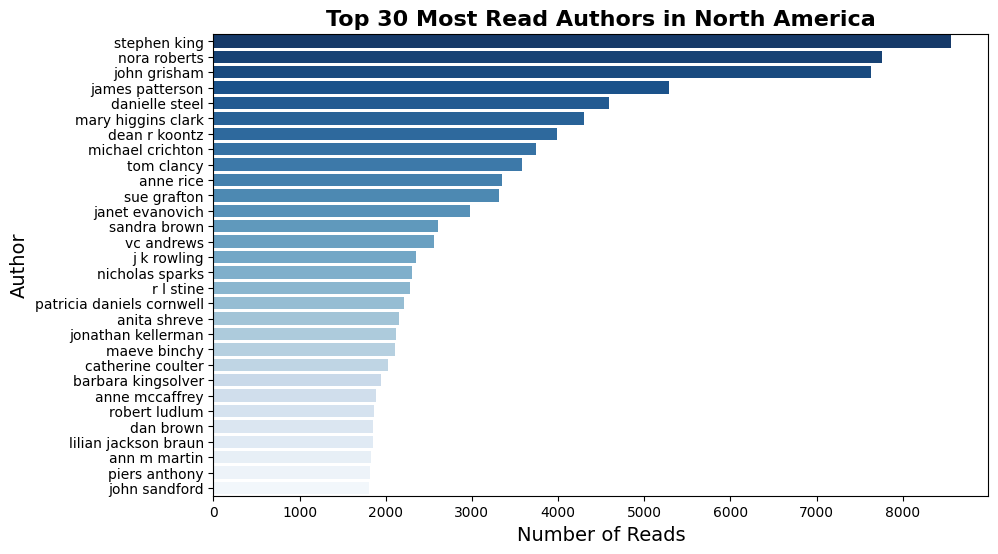

In [62]:
# Optional: Plot the result for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='read_count', y='mod_book_author', data=top_30_authors_na, palette='Blues_r')

# Set the title and labels
plt.title('Top 30 Most Read Authors in North America', fontsize=16, fontweight='bold')
plt.xlabel('Number of Reads', fontsize=14)
plt.ylabel('Author', fontsize=14)

# Display the plot
plt.show()

### Flagging authors ? 

In [63]:
# Create a dictionary of authors and their problematic behavior
problematic_authors = {
    'john grisham': 'Made problematic comments in 2014. Please make your own research for more information. TW: Child pornography',
    'james patterson': 'Made problematic comments in 2022. Please make your own research for more information.',
    'j k rowling': 'Made transphobic comments. Please make your own research for more information.',
    'nicholas sparks': 'Accused of promoting racism, homophobia and discrimination. please make your own research for more information.',
    'piers anthony' : 'Inappropriate comments in his work. Please make your own research for more information. TW: Underage sexual relations'
}

# Create a new column with problematic messages
all_cleaned['problematic_author'] = all_cleaned['mod_book_author'].apply(
    lambda author: problematic_authors.get(author, '')
)

In [64]:
all_cleaned.head()

,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,location,age,age_numeric,age_bins,mod_book_author,mod_book_title,mod_publisher,country,continent,problematic_author
0,0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2.0,0.0,"stockton, california, usa",18.0,18.0,Teenager,mark p o morford,classical mythology,oxford university press,usa,North America,
1,1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8.0,5.0,"timmins, ontario, canada",unknown,NaN,unknown,richard bruce wright,clara callan,harperflamingo canada,canada,North America,
2,2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400.0,0.0,"ottawa, ontario, canada",49.0,49.0,Adult,richard bruce wright,clara callan,harperflamingo canada,canada,North America,
3,3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676.0,8.0,"n/a, n/a, n/a",unknown,NaN,unknown,richard bruce wright,clara callan,harperflamingo canada,NaN,Unknown,
4,4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385.0,0.0,"sudbury, ontario, canada",unknown,NaN,unknown,richard bruce wright,clara callan,harperflamingo canada,canada,North America,


In [65]:
# Query function for the recommendation system
def search(query, vectorizer):
    # Step 1: Clean the query
    processed = re.sub('[^a-zA-Z0-9]', ' ', query.lower())
    
    # Step 2: Transform the query into a vector using the vectorizer
    query_vector = vectorizer.transform([processed])
    
    # Step 3: Calculate the cosine similarity between the query vector and the tfidf matrix
    similarity = cosine_similarity(query_vector, tdidf).flatten()  # Flatten the matrix into a 1D array
    
    # Step 4: Find the indices of the 10 most similar books
    indices = np.argpartition(similarity, -10)[-10:]
    
    # Step 5: Retrieve the books with the highest similarities
    results = ratings.iloc[indices]
    
    # Step 6: Sort the results by rating count
    results = results.sort_values(by='rating_count', ascending=False).head(10)
    
    # Step 7: Loop through the results and add problematic author descriptions if applicable
    for index, row in results.iterrows():
        book_title = row['mod_book_title']
        author = row['mod_book_author']
        # rating = row['book_rating']
        rating_count = row['rating_count']
        
        # Print the book details
        print(f"Book: {book_title} by {author}")
        # print(f"Rating: {rating}, Number of Ratings: {rating_count}")
        
        # Check if the author is flagged as problematic and print the message if applicable
        if author in problematic_authors:
            print(f"⚠️ {problematic_authors[author]}")
        
        print() 

    return results

# Example usage:
results = search('Harry Potter', vectorizer)

Book: harry potter and the sorcerers stone harry potter paperback by j k rowling
⚠️ Made transphobic comments. Please make your own research for more information.

Book: harry potter and the chamber of secrets book 2 by j k rowling
⚠️ Made transphobic comments. Please make your own research for more information.

Book: harry potter and the prisoner of azkaban book 3 by j k rowling
⚠️ Made transphobic comments. Please make your own research for more information.

Book: harry potter and the goblet of fire book 4 by j k rowling
⚠️ Made transphobic comments. Please make your own research for more information.

Book: harry potter and the goblet of fire book 4 by j k rowling
⚠️ Made transphobic comments. Please make your own research for more information.

Book: harry potter and the chamber of secrets book 2 by j k rowling
⚠️ Made transphobic comments. Please make your own research for more information.

Book: harry potter and the sorcerers stone book 1 by j k rowling
⚠️ Made transphobic com